# Random Forest

In [1]:
#-*- coding: utf-8 -*-
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split
df = pd.read_csv('DrinkingDataFinal.csv', index_col='date', parse_dates=True)

In [2]:
# train-test split
data_train, data_test = train_test_split(df, test_size=0.3, random_state=0)

# select the fountain point to predict (this could be any site)
w = df.columns
p = w[w.str.contains('Alley Pond Park--73.74724556_40.74169346')]

In [3]:
# training and testing set (only with the chosen site)
y_train = data_train[p].sort_index()
y_test = data_test[p].sort_index()

# select the last 2 columns as features: prcp and tavg
X_train = data_train.iloc[:,-2:].sort_index()
X_test = data_test.iloc[:,-2:].sort_index()
# print(X_test,X_train,y_train,y_test)

In [4]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2003, 2)
(2003, 3)
(859, 2)
(859, 3)


In [5]:
# train and test the model
rf = RandomForestRegressor(n_estimators=5, max_depth=2, random_state=0)
rf.fit(X_train, y_train)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)
y = pd.DataFrame(y_test_pred, columns=p)

In [6]:
# evaluation
from sklearn.metrics \
import mean_squared_error, explained_variance_score, mean_absolute_error, r2_score, accuracy_score
print ('Random Forest Training Set Evaluation:')
print ('Training R-squared:', r2_score(y_train, y_train_pred))
print ('Training MSE:', mean_squared_error(y_train, y_train_pred))
print ('Training MAE:', mean_absolute_error(y_train, y_train_pred))
print ('Training Explained Variance Score:',explained_variance_score(y_train,y_train_pred))

Random Forest Training Set Evaluation:
Training R-squared: 0.06763555877453269
Training MSE: 0.007003707378297776
Training MAE: 0.0541268499777444
Training Explained Variance Score: 0.0676407247349478


In [7]:
print ('Random Forest Testing Set Evaluation:')
print ('Testing R-squared:', r2_score(y_test, y_test_pred))
print ('Testing MSE:', mean_squared_error(y_test, y_test_pred))
print ('Testing MAE:', mean_absolute_error(y_test, y_test_pred))
print ('Testing Explained Variance Score:', explained_variance_score(y_test, y_test_pred))

Random Forest Testing Set Evaluation:
Training R-squared: 0.038459084975250045
Testing MSE: 0.007274447419143737
Testing MAE: 0.05501095052385358
Testing Explained Variance Score: 0.03906853040906074


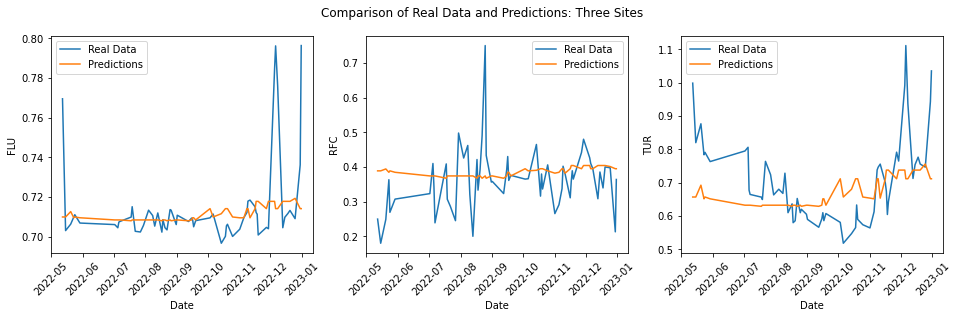

In [8]:
# see how the model is doing for the last 60 days in y_test
last_60_days = y_test.iloc[-60:]
predictions = y.iloc[-60:]
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 4), sharey=False)
y_label = ['FLU', 'RFC', 'TUR']

for i in range(3):
    # Plot the real data in blue
    axs[i].plot(last_60_days.index, last_60_days.iloc[:, i], label='Real Data')

    # Plot the predicted data in red
    axs[i].plot(last_60_days.index, predictions.iloc[:, i], label='Predictions')

    # Add labels and legend to the plot
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel(y_label[i])
    axs[i].legend()
    axs[i].tick_params(axis='x', rotation=45) 

# Show the plot
fig.suptitle('Comparison of Real Data and Predictions: Three Sites')
plt.show()

# DNN

In [9]:
import matplotlib.pyplot as plt
import keras
import pickle
import warnings
import datetime
from sklearn.impute import SimpleImputer
plt.rcParams['axes.unicode_minus'] = False  # standardize minus sign
warnings.filterwarnings('ignore')
data = pd.read_csv('DrinkingDataFinal.csv', index_col='date', parse_dates=True)
print(data.shape)
data = data.astype(float)

(2862, 6726)


In [10]:
# as the data is large, we just choose certain points to predict (we choose 2 here)
w = data.columns
p1 = w[w.str.contains('Alley Pond Park--73.74724556_40.74169346')]
p2 = w[w.str.contains('Alley Park--73.74463703_40.74790938')]
p = p1.append(p2)

# set n as the number of columns to predict
n = len(p)
data = data[p].join(data.iloc[:, -2:])
print(data.shape)

(2862, 8)


In [11]:
parts = 14
this_one = data.iloc[parts:]
print(this_one.shape)
bak_index = this_one.index
print(this_one.index.shape)

# get data of the last 14 days and horizontally join it to data on the right
for k in range(1, parts+1):
    last_one = data.iloc[(parts - k):(this_one.shape[0] - k + parts)]
    this_one.set_index(last_one.index, drop=True, inplace=True)
    this_one = this_one.join(last_one, lsuffix='', rsuffix="_p" + str(k))
    
# restore indexing (which was altered during the loop above) 
this_one.set_index(bak_index, drop=True, inplace=True)

# get stage-0 data (the current day)
t0 = this_one.iloc[:, 0:n]

(2848, 8)
(2848,)


In [12]:
# min and ptp for each columns
t0_min = t0.apply(lambda x: np.min(x), axis=0).values
t0_ptp = t0.apply(lambda x: np.ptp(x), axis=0).values

# normalization to values from 0 to 1
this_one = this_one.apply(lambda x: (x - np.min(x)) / np.ptp(x), axis=0)

In [13]:
# extract data of the last m month as the testing set
m = 2
test_data = this_one.iloc[-30*m:]

# other data will become the training set
train_data = this_one.iloc[:-30*m]

# get train_y_df (first 6724 cols of train_data) and interpolate
train_y_df = train_data.iloc[:, 0:n]
train_y_df = train_y_df.interpolate()

# check whether there are null values in each column
w = train_y_df.columns
for i in range(train_y_df.shape[1]):
    p = train_y_df[w[i]].isnull().sum()
    if p > 0:
        print(w[i], p)

# turn train_y_df into a np array
train_y = np.array(train_y_df)

# get train_x (data of the previous 14 days) and turn it into a np array
train_x_df = train_data.iloc[:, n:]
train_x = np.array(train_x_df)

# similarly, get test_x and test_y
test_y_df = test_data.iloc[:, 0:n]
test_y = np.array(test_y_df)
test_x_df = test_data.iloc[:, n:]
test_x = np.array(test_x_df)

# this serves as a non-standardized test_y (for evaluation purpose)
test_y_real = t0.iloc[-30*m:]

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(2788, 114)
(2788, 6)
(60, 114)
(60, 6)


In [14]:
# build the DNN model
# we tried several epoch values and found 80 epochs is the best
from IPython import display

init = keras.initializers.glorot_uniform(seed=0)
simple_adam = keras.optimizers.Adam()
model = keras.models.Sequential()
model.add(keras.layers.Dense(units=512, input_dim=(n+2)*parts+2, kernel_initializer=init, activation='relu'))
model.add(keras.layers.Dense(units=256, kernel_initializer=init, activation='relu'))
model.add(keras.layers.Dense(units=128, kernel_initializer=init, activation='relu'))
model.add(keras.layers.Dense(units=64, kernel_initializer=init, activation='relu'))
model.add(keras.layers.Dense(units=32, kernel_initializer=init, activation='relu'))
model.add(keras.layers.Dense(units=16, kernel_initializer=init, activation='relu'))
model.add(keras.layers.Dense(units=8, kernel_initializer=init, activation='relu'))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.Dense(units=n, kernel_initializer=init, activation='tanh'))
model.compile(loss='mse', optimizer=simple_adam, metrics=['accuracy'])
history = model.fit(train_x, train_y, epochs=80, batch_size=30, shuffle=True, verbose=True, validation_data=(test_x, test_y))
display.clear_output()

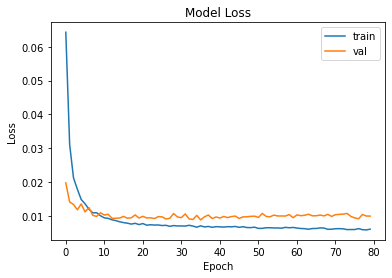

In [15]:
# access the history to see whether the model underfit or overfit
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

2/2 [==============================] - 0s 2ms/step


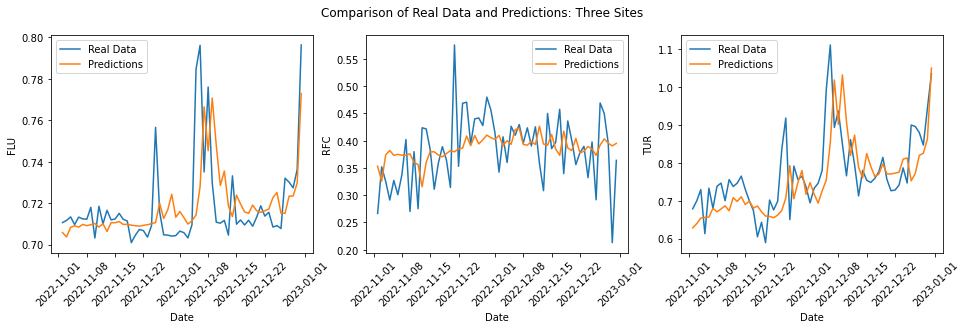

In [16]:
# predict on test_x and restore data from normalization
pred_y = model.predict(test_x)
pred_y = (pred_y * t0_ptp) + t0_min

preddf = pd.DataFrame(pred_y, columns = t0.columns)
preddf.index = data.index[-30*m:]

# choose 3 columns and see how the model is doing
last_months = test_y_real.iloc[:, :3]
predictions = preddf.iloc[:, :3]
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 4), sharey=False)
y_label = ['FLU', 'RFC', 'TUR']

for i in range(3):
    # Plot the real data in blue
    axs[i].plot(last_months.index, last_months.iloc[:, i], label='Real Data')

    # Plot the predicted data in red
    axs[i].plot(last_months.index, predictions.iloc[:, i], label='Predictions')

    # Add labels and legend to the plot
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel(y_label[i])
    axs[i].legend()
    axs[i].tick_params(axis='x', rotation=45) 

# Show the plot
fig.suptitle('Comparison of Real Data and Predictions: Three Sites')
plt.show()

In [17]:
# evaluation
print ('DNN Testing Set Evaluation:')
print ('Testing R-squared:', r2_score(test_y_real, pred_y))
print ('Testing MSE:', mean_squared_error(test_y_real, pred_y))
print ('Testing MAE:', mean_absolute_error(test_y_real, pred_y))

DNN Training Set Evaluation:
Training R-squared: 0.17344171695384858
Training MSE: 0.0038266884032746584
Training MAE: 0.041280543727298606


In [18]:
# feature importance
def permutation_feature_importance(model, X, y, metric, num_rounds=5):
    baseline_score, _ = model.evaluate(X, y, verbose=0)
    feature_importance = np.zeros(X.shape[1])
    for feature in range(X.shape[1]):
        for i in range(num_rounds):
            X_permuted = X.copy()
            X_permuted[:, feature] = np.random.permutation(X[:, feature])
            score, _ = model.evaluate(X_permuted, y, verbose=0)
            feature_importance[feature] += score - baseline_score
    feature_importance /= num_rounds
    return feature_importance

fi = permutation_feature_importance(model, test_x, test_y, 'mse')
top_10_indices = np.argsort(fi)[-10:]
top_10_values = fi[top_10_indices]
train_x_df.columns[top_10_indices]

Index(['RFC_Alley Park--73.74463703_40.74790938_p1',
       'RFC_Alley Park--73.74463703_40.74790938_p10', 'tavg_p14',
       'FLU_Alley Pond Park--73.74724556_40.74169346_p3', 'prcp_p8',
       'FLU_Alley Pond Park--73.74724556_40.74169346_p5',
       'RFC_Alley Pond Park--73.74724556_40.74169346_p2',
       'TUR_Alley Park--73.74463703_40.74790938_p1',
       'RFC_Alley Park--73.74463703_40.74790938_p2',
       'FLU_Alley Pond Park--73.74724556_40.74169346_p12'],
      dtype='object')

# LSTM

In [19]:
from keras.layers import LSTM, Dense
from keras.models import Sequential
import missingno as msno
data = pd.read_csv('DrinkingDataFinal.csv', index_col='date', parse_dates=True)
print(data.shape)

(2862, 6726)


In [20]:
# as the data is large, we just choose certain point(s) to predict (we choose 2 here)
w = data.columns
p1 = w[w.str.contains('Alley Pond Park--73.74724556_40.74169346')]
p2 = w[w.str.contains('Alley Park--73.74463703_40.74790938')]
p = p1.append(p2)
n = len(p)
data = data[p].join(data.iloc[:, -2:])
print(data.shape)

# for evaluation purpose
y_test_real = data.iloc[-60:, :n]

# normalization
vmean = data.apply(lambda x:np.mean(x))
vstd = data.apply(lambda x:np.std(x))
t0 = data.apply(lambda x:(x - np.mean(x)) / np.std(x)).values

(2862, 8)


In [21]:
# SEQLEN: 2 weeks; pre_len: m month
SEQLEN = 14
dim_in = n+2
dim_out = n
pre_len = 30*m

# train test split
X_train = np.zeros((t0.shape[0] - SEQLEN - pre_len, SEQLEN, dim_in))
Y_train = np.zeros((t0.shape[0] - SEQLEN - pre_len, dim_out),)
X_test = np.zeros((pre_len, SEQLEN, dim_in))
Y_test = np.zeros((pre_len, dim_out),)

# create sequential data
for i in range(SEQLEN, t0.shape[0] - pre_len):
    Y_train[i - SEQLEN] = t0[i][0:n]
    X_train[i - SEQLEN] = t0[(i-SEQLEN):i]
for i in range(t0.shape[0] - pre_len, t0.shape[0]):
    Y_test[i - t0.shape[0] + pre_len] = t0[i][0:n]
    X_test[i - t0.shape[0] + pre_len] = t0[(i-SEQLEN):i]

In [22]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(2788, 14, 8)
(2788, 6)
(60, 14, 8)
(60, 6)


In [23]:
# build the model
import tensorflow as tf
opt = tf.keras.optimizers.experimental.RMSprop(learning_rate=0.0001)
model = Sequential()
model.add(LSTM(256, input_shape=(SEQLEN, dim_in), activation='sigmoid', recurrent_dropout=0.01))
model.add(Dense(dim_out,activation='linear'))
#model.compile(loss = 'mean_squared_error', optimizer = 'rmsprop', metrics=['accuracy'])
model.compile(loss = 'mean_squared_error', optimizer = opt, metrics=['accuracy'])

history = model.fit(X_train, Y_train, epochs=100, batch_size=30, validation_data=(X_test, Y_test))
display.clear_output()

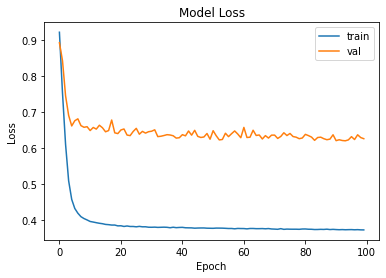

In [24]:
# access the history to see whether the model underfit or overfit
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [25]:
# predict on the test set, and restore data from normalization
y_pred = model.predict(X_test) * vstd[0:n].values + vmean[0:n].values
preddf = pd.DataFrame(y_pred, columns=data.columns[0:n])
preddf.index = data.index[-30*m:]
#preddf

2/2 [==============================] - 0s 10ms/step


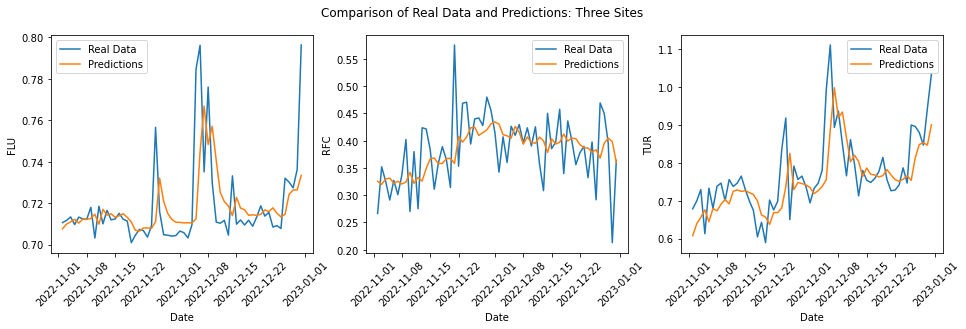

In [26]:
# choose 3 columns and see how the model is doing
last_months = y_test_real.iloc[:, :3]
predictions = preddf.iloc[:, :3]
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 4), sharey=False)
y_label = ['FLU', 'RFC', 'TUR']

for i in range(3):
    # Plot the real data in blue
    axs[i].plot(last_months.index, last_months.iloc[:, i], label='Real Data')

    # Plot the predicted data in red
    axs[i].plot(last_months.index, predictions.iloc[:, i], label='Predictions')

    # Add labels and legend to the plot
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel(y_label[i])
    axs[i].legend()
    axs[i].tick_params(axis='x', rotation=45) 

# Show the plot
fig.suptitle('Comparison of Real Data and Predictions: Three Sites')
plt.show()

In [27]:
# evaluation
print ('LSTM Testing Set Evaluation:')
print ('Testing R-squared:', r2_score(y_test_real, y_pred))
print ('Testing MSE:', mean_squared_error(y_test_real, y_pred))
print ('Testing MAE:', mean_absolute_error(y_test_real, y_pred))

LSTM Training Set Evaluation:
Training R-squared: 0.24870132604606474
Training MSE: 0.0033508320491890645
Training MAE: 0.037211977318749534


In [28]:
# feature importance
def permutation_feature_importance(model, X, y, metric, num_rounds=5):
    baseline_score, _ = model.evaluate(X, y, verbose=0)
    feature_importance = np.zeros(X.shape[1])
    for feature in range(X.shape[1]):
        for i in range(num_rounds):
            X_permuted = X.copy()
            X_permuted[:, feature] = np.random.permutation(X[:, feature])
            score, _ = model.evaluate(X_permuted, y, verbose=0)
            feature_importance[feature] += score - baseline_score
    feature_importance /= num_rounds
    return feature_importance

fi = permutation_feature_importance(model, X_test, Y_test, 'mse')
top_10_indices = np.argsort(fi)[-10:]
top_10_values = fi[top_10_indices]
train_x_df.columns[top_10_indices]

Index(['FLU_Alley Park--73.74463703_40.74790938_p1', 'tavg', 'prcp',
       'RFC_Alley Pond Park--73.74724556_40.74169346_p1',
       'FLU_Alley Pond Park--73.74724556_40.74169346_p1',
       'TUR_Alley Pond Park--73.74724556_40.74169346_p1',
       'RFC_Alley Park--73.74463703_40.74790938_p1', 'prcp_p1',
       'TUR_Alley Pond Park--73.74724556_40.74169346_p2',
       'FLU_Alley Park--73.74463703_40.74790938_p2'],
      dtype='object')

# RNN

In [29]:
from keras.layers import SimpleRNN, Dense
from keras.models import Sequential

# use the same data from LSTM
opt = tf.keras.optimizers.experimental.RMSprop(learning_rate=0.0001)
model = Sequential()
model.add(SimpleRNN(128, input_shape=(SEQLEN, dim_in), activation='sigmoid', recurrent_dropout=0.01))
model.add(Dense(dim_out,activation='linear'))
model.compile(loss = 'mean_squared_error', optimizer=opt, metrics=['accuracy'])
history = model.fit(X_train, Y_train, epochs=50, batch_size=7, validation_data=(X_test, Y_test))
display.clear_output()

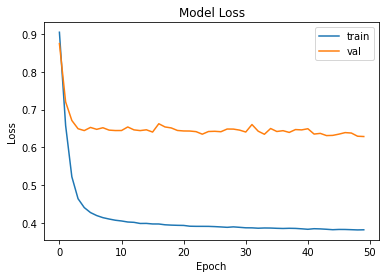

In [30]:
# access the history to see whether the model underfit or overfit
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [31]:
# predict on the test set, and restore data from normalization
pred_y = model.predict(X_test) * vstd[0:n].values + vmean[0:n].values
preddf = pd.DataFrame(pred_y, columns=data.columns[0:n])
preddf.index = data.index[-30*m:]

2/2 [==============================] - 0s 3ms/step


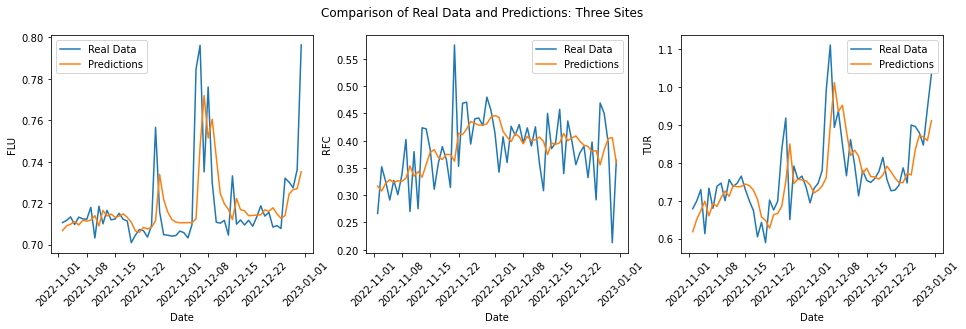

In [32]:
# choose 3 columns and see how the model is doing
last_months = y_test_real.iloc[:, :3]
predictions = preddf.iloc[:, :3]
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 4), sharey=False)
y_label = ['FLU', 'RFC', 'TUR']

for i in range(3):
    # Plot the real data in blue
    axs[i].plot(last_months.index, last_months.iloc[:, i], label='Real Data')

    # Plot the predicted data in red
    axs[i].plot(last_months.index, predictions.iloc[:, i], label='Predictions')

    # Add labels and legend to the plot
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel(y_label[i])
    axs[i].legend()
    axs[i].tick_params(axis='x', rotation=45) 

# Show the plot
fig.suptitle('Comparison of Real Data and Predictions: Three Sites')
plt.show()

In [33]:
# evaluation
print ('RNN Testing Set Evaluation:')
print ('Testing R-squared:', r2_score(y_test_real, y_pred))
print ('Testing MSE:', mean_squared_error(y_test_real, y_pred))
print ('Testing MAE:', mean_absolute_error(y_test_real, y_pred))

RNN Training Set Evaluation:
Training R-squared: 0.24870132604606474
Training MSE: 0.0033508320491890645
Training MAE: 0.037211977318749534
